# Enunciado
   Uma refinaria produz três tipos de gasolina: verde, azul e comum. Cada tipo requer gasolina pura, octana e aditivo, que estão disponíveis nas quantidades de 9.000.000, 4.800.000 e 2.200.000 litros por semana, respectivamente. As especificações de cada tipo são:

Um litro de gasolina verde requer 0,22 litro de gasolina pura, 0,50 litro de octana e 0,28 litro de aditivo;

Um litro de gasolina azul requer 0,52 litro de gasolina pura, 0,34 litro de octana e 0,14 litro de aditivo;

Um litro de gasolina comum requer 0,74 litro de gasolina pura, 0,20 litro de octana e 0,06 litro de aditivo.

Como regra de produção, baseada na demanda de mercado, o planejamento da refinaria estipulou que:

a quantidade de gasolina comum deve ser no mínimo igual a 16 vezes a quantidade de gasolina verde;

a quantidade de gasolina azul deve ser no máximo igual a 600.000 litros por semana.

A empresa sabe que cada litro de gasolina verde, azul e comum proporciona uma margem de contribuição para o lucro de R$ 0,30, R$ 0,25 e R$ 0,20, respectivamente.

Pede-se: elaborar um modelo que maximize a margem total de contribuição para o lucro.

In [ ]:
# PASSO 1: Importar a biblioteca Gurobi
import gurobipy as gp
from gurobipy import GRB

try:
    # DADOS DO PROBLEMA 
    gasolinas = ['GasolinaVerde', 'GasolinaAzul', 'GasolinaComun']

    # Dicionário com o lucro (margem) 
    lucro = {
        'GasolinaVerde': 0.3,
        'GasolinaAzul': 0.25,  
        'GasolinaComun': 0.20
    }

    # Dicionário com os limites (RHS) das restrições de recursos
    limites = {
        'GasolinaPura': 9000000,
        'Octana': 4800000,
        'Aditivo': 2200000
    }

    # Dicionário aninhado (matriz) com o consumo de recursos por produto
    # Formato: consumo[recurso][produto]
    consumo = {
        'GasolinaPura': {'GasolinaVerde': 0.22, 'GasolinaAzul': 0.52, 'GasolinaComun': 0.74},
        'Octana':       {'GasolinaVerde': 0.5,  'GasolinaAzul': 0.34, 'GasolinaComun': 0.20},
        'Aditivo':      {'GasolinaVerde': 0.28, 'GasolinaAzul': 0.14, 'GasolinaComun': 0.06}
    }

    # PASSO 2: Criação do Modelo
    modelo = gp.Model("maximar_lucro_da_Gasolina")

    # PASSO 3: Variáveis de Decisão 
    # Usamos um dicionário 'x' para armazenar as variáveis do Gurobi
    x = {}
    for g in gasolinas:
        x[g] = modelo.addVar(vtype=GRB.CONTINUOUS, name=g)
    

    # PASSO 4: Função Objetivo (criada com quicksum e dicionário)
    # gp.quicksum é uma forma otimizada de criar somatórios
    modelo.setObjective(
        gp.quicksum(lucro[g] * x[g] for g in gasolinas),
        GRB.MAXIMIZE
    )

    # PASSO 5: Restrições 

    # Restrições de Limite de Recursos (usando os dicionários 'consumo' e 'limites')
    # Itera sobre cada recurso (GasolinaPura, Octana, Aditivo)
    for r in limites.keys():
        modelo.addConstr(
            # Cria o somatório (LHS) dinamicamente para o recurso 'r'
            gp.quicksum(consumo[r][g] * x[g] for g in gasolinas) <= limites[r],
            name=f"limite_{r}"
        )

    # Restrições Específicas (agora usam as chaves do dicionário 'x')
    modelo.addConstr(x['GasolinaComun'] - 16 * x['GasolinaVerde'] >= 0, "regra_comum_vs_verde")
    modelo.addConstr(x['GasolinaAzul'] <= 600000, "maximo_gasolina_azul")

    # PASSO 6: Otimizar o modelo
    modelo.optimize()

    # PASSO 7: Apresentar Resultados
    if modelo.status == GRB.OPTIMAL:
        print("-" * 40)
        print("SOLUÇÃO ÓTIMA ENCONTRADA")
        print("-" * 40)
        print(f"Margem de Contribuição Máxima (Lucro): {modelo.objVal:,.2f}".replace(",", "."))
        print("-" * 40)
        print("Valores para as variáveis de decisão:")
        
        # Imprime o valor de cada variável (usando o loop 'for' e o dicionário 'x')
        # Iteramos pela nossa lista 'gasolinas' para garantir a ordem
        for g in gasolinas:
            # Acessamos a variável e seu valor pelo dicionário 'x'
            if x[g].x > 1e-6: # Só imprime se for um valor relevante
                print(f"  - {x[g].varName}: {round(x[g].x, 2)}")
        
        print("-" * 40)
    else:
        print("Não foi encontrada uma solução ótima. Verifique seu modelo.")

except gp.GurobiError as e:
    print(f"Ocorreu um erro no Gurobi: {e.message}")
except Exception as e:
    print(f"Ocorreu um erro geral: {e}")

# Resultados
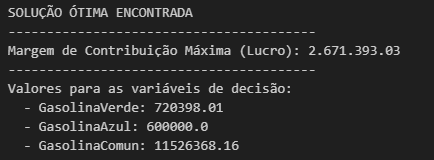